<a href="https://colab.research.google.com/github/ncsu-geoforall-lab/geomorphometry2025_workshop/blob/main/geomorphometry_2025_workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workshop: Propagating DEM Uncertainty to Stream Extraction using GRASS

### Abstract

GRASS is an open-source geospatial processing engine. With over 400 tools available in the core distribution and an additional 400+ tools available as extensions, GRASS has broad applicability in the Earth Sciences and geomorphometry in particular. In this workshop, we will give an introduction to GRASS and demonstrate some of the geomorphometry tools available in GRASS. Specifically, we will show how to compute stream extraction uncertainty using a workflow adapted from Hengl [(2007)](https://publications.jrc.ec.europa.eu/repository/handle/JRC38153) and Hengl et al. [(2010)](https://hess.copernicus.org/articles/14/1153/2010/). In this tutorial, we will:
* [Create a new GRASS project](#start)
* [Download and import elevation data](#data) of near Perugia using GRASS data fetching tools
* [Use R’s kriging functions (gstat)](#R) to create 10 iterations of a DEM
* [Extract streams](#uncert) from each of the 10 DEMs to compute stream uncertainty

Check out the publication associated with the notebook on Zenodo:

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.15283714.svg)](https://doi.org/10.5281/zenodo.15283714)


---


### Install GRASS and Get Workshop Materials

The following cell installs GRASS from the ubuntugis-unstable ppa. It will take a minute to run.

In [2]:
!add-apt-repository -y ppa:ubuntugis/ubuntugis-unstable
!apt update
!apt-get install -y grass-core grass-dev

PPA publishes dbgsym, you may need to include 'main/debug' component
Repository: 'deb https://ppa.launchpadcontent.net/ubuntugis/ubuntugis-unstable/ubuntu/ jammy main'
Description:
Unstable releases of Ubuntu GIS packages. These releases are more bleeding edge and while generally they should work well, they dont receive the same amount of quality assurance as our stable releases do.
More info: https://launchpad.net/~ubuntugis/+archive/ubuntu/ubuntugis-unstable
Adding repository.
Adding deb entry to /etc/apt/sources.list.d/ubuntugis-ubuntu-ubuntugis-unstable-jammy.list
Adding disabled deb-src entry to /etc/apt/sources.list.d/ubuntugis-ubuntu-ubuntugis-unstable-jammy.list
Adding key to /etc/apt/trusted.gpg.d/ubuntugis-ubuntu-ubuntugis-unstable.gpg with fingerprint 2EC86B48E6A9F326623CD22FFF0E7BBEC491C6A1
Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:3 https://developer.download.nvidia.com/co

We can check GRASS installed and see what version we have using:

In [3]:
!grass --version

GRASS GIS 8.4.1
Geographic Resources Analysis Support System (GRASS) is Copyright,
1999-2025 by the GRASS Development Team, and licensed under terms of the
GNU General Public License (GPL) version >=2.

This GRASS GIS 8.4.1 release is coordinated and produced by
the GRASS Development Team with contributions from all over the world.

This program is distributed in the hope that it will be useful, but
WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU
General Public License for more details.


<a name="start"></a>

---

## Create a New GRASS Project and Start GRASS

First, let's import all the Python libraries we'll need.

In [4]:
import sys
import subprocess
import pandas as pd
from IPython.display import display
from ipyleaflet import WMSLayer, Marker

**Importing the GRASS Python API**

We are going to import the GRASS Python API (`grass.script`) and the GRASS Jupyter package (`grass.jupyter`). But first, we'll need to ask `grass` to check it's `--config` to see where the python packages are then add them to the system path before we can import them.

We use `subprocess.check_output` to find the path and `sys.path.append` to add it to the path.

In [5]:
sys.path.append(
    subprocess.check_output(["grass", "--config", "python_path"], text=True).strip()
)

Then, we can import the Python API and GRASS Jupyter packages.

In [6]:
import grass.script as gs
import grass.jupyter as gj

**Starting a New Project**

Now, we create a new project called "geomorphometry_workshop". Projects are defined by a Coordinate Reference System (CRS). We can set the CRS from a georeferenced file (such as a Geotiff) or an EPSG string. Here, we use [EPSG 32632](https://epsg.io/32632), CRS WGS 84/UTM zone 32N (EPSG:32632).

In [7]:
gs.create_project("geomorphometry_workshop", epsg="32632")

You should now see a new folder created called "geomorphometry_workshop". This will contain all of the data for our project and is organized by GRASS's native data format. This makes GRASS _fast_, _scalable_, and _avoids projection mismatches_.

We start a GRASS session in our new project.

In [8]:
gj.init("geomorphometry_workshop");

**Introducting the "Computational Region"**

Finally, let's set our computational region using [`g.region`](https://grass.osgeo.org/grass85/manuals/g.region.html). The computational region will determine what data is imported from the cloud so we need to set it before continuing.

Upon creating a project, the computational region is empty.

In [9]:
print(gs.read_command("g.region", flags="p"))

projection: 1 (UTM)
zone:       32
datum:      wgs84
ellipsoid:  wgs84
north:      1
south:      0
west:       0
east:       1
nsres:      1
ewres:      1
rows:       1
cols:       1
cells:      1



There are lots of ways to set the computional region, from a georeferenced file or existing data layer to relative operations grow which adds cells around the previous region. Here, we set our computational region with coordinates and set the resolution to 10 meters.

In [10]:
aoi_bbox = {
	"north": 4779210,
	"south": 4778120,
	"west": 779180,
	"east": 780630
}

print(
    gs.read_command(
        "g.region", n=aoi_bbox["north"], s=aoi_bbox["south"], e=aoi_bbox["east"], w=aoi_bbox["west"], res=10, flags="p"
    )
)

projection: 1 (UTM)
zone:       32
datum:      wgs84
ellipsoid:  wgs84
north:      4779210
south:      4778120
west:       779180
east:       780630
nsres:      10
ewres:      10
rows:       109
cols:       145
cells:      15805



<a name="data"></a>

---

## Download and Import Data

Right now, our project has no data in it:

In [11]:
gs.read_command("g.list", type="all")

''

We're going to use a DEM from the TINItaly dataset. Let's get an overview of the dataset using a quick WMS visualization.

First, let's create some WMSLayers:

In [12]:
tinitaly_wms = WMSLayer(
    name="TINItaly_1.1 HSV (WMS)",
    url="http://tinitaly.pi.ingv.it/TINItaly_1_1/wms?service=WMS",
    layers="TINItaly_1.1:tinitaly_hsv",
    format="image/png",
    transparent=True,
    attribution="HSV Elevation Data © 2023 TINItaly 1.1",
)

tinitaly_slope = WMSLayer(
    name="TINItaly_1.1 Slope (WMS)",
    url="http://tinitaly.pi.ingv.it/TINItaly_1_1/wms?service=WMS",
    layers="TINItaly_1.1:tinitaly_slope",
    format="image/png",
    transparent=True,
    attribution="Slope Data © 2023 TINItaly 1.1",
)

nasa_wms = WMSLayer(
    name="NASA SRTM RAMP2 TOPO (WMS)",
    url="https://neo.gsfc.nasa.gov/wms/wms?service=WMS",
    layers="SRTM_RAMP2_TOPO",
    format="image/png",
    transparent=True,
    styles="rgb",
    attribution="SRTM RAMP2 TOPO © 2025 NASA ",
)

perugia = Marker(
    name="Perugia (Marker)",
    location=(43.11203, 12.38914),
    draggable=False,
    title="Perugia",
    alt="Perugia",
    # icon="fa-flag",
)

And create a vector box of our region to add:

In [13]:
gs.run_command("v.in.region", output="region")

In [14]:
nasa_basemap = "NASAGIBS BlueMarble"
m = gj.InteractiveMap(height=600, width=800, tiles=nasa_basemap, use_region=True)
m.map.add(tinitaly_wms)
m.map.add(tinitaly_slope)
m.map.add(nasa_wms)
m.map.add(perugia)
m.add_vector("region")
m.add_layer_control()
m.map.zoom = 6
m.map.center = (43.11203, 12.38914)
display(m.show())

Map(center=[43.11203, 12.38914], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', '…

Now we can import our DEM. We will use the [r.import](https://grass.osgeo.org/manuals/grass85/r.import.html) command to import a DEM file. The DEM file is a [Cloud Optimized GeoTIFF (COG)](https://cogeo.org/), and we will specify the output name as "dem". *r.import* will automatically reproject the DEM to the project's CRS.

In [15]:
gs.run_command(
    "r.import",
    input="https://storage.googleapis.com/geomorphometry/w47575_s10.cog.tif",
    output="dem",
    title="TINItaly DEM 10m",
    resample="bicubic_f",
    resolution="region",
    extent="region",
    overwrite=True,
)

Let's get some basic information about our DEM. We'll use the [`r.info`](https://grass.osgeo.org/grass85/manuals/r.info.html) and [`r.univar`](https://grass.osgeo.org/grass85/manuals/r.univar.html) tools to get the rasters metadata and univariate statistics respectively.

In [16]:
print(gs.read_command("r.info", map="dem"))

 +----------------------------------------------------------------------------+
 | Map:      dem                            Date: Thu Jun 12 16:20:02 2025    |
 | Mapset:   PERMANENT                      Login of Creator: root            |
 | Project:  geomorphometry_workshop                                          |
 | DataBase: /content                                                         |
 | Title:                                                                     |
 | Timestamp: none                                                            |
 |----------------------------------------------------------------------------|
 |                                                                            |
 |   Type of Map:  raster               Number of Categories: 0               |
 |   Data Type:    FCELL                Semantic label: (none)                |
 |   Rows:         109                                                        |
 |   Columns:      145                  

**Try it yourself!**

Using the cell above as a template, compute the univariate statistics using [`r.univar`](https://grass.osgeo.org/grass85/manuals/r.univar.html).

<details>
    <summary>👉 <b>click to see hint</b></summary>
  
Run `!r.univar --help` to see the paramters.
</details>


<details>
    <summary>👉 <b>click to see solution</b></summary>
    
```python
print(gs.read_command("r.univar", map="dem", flags="e"))
```
</details>


Now let's look at our imported DEM using the grass.jupyter Map module.

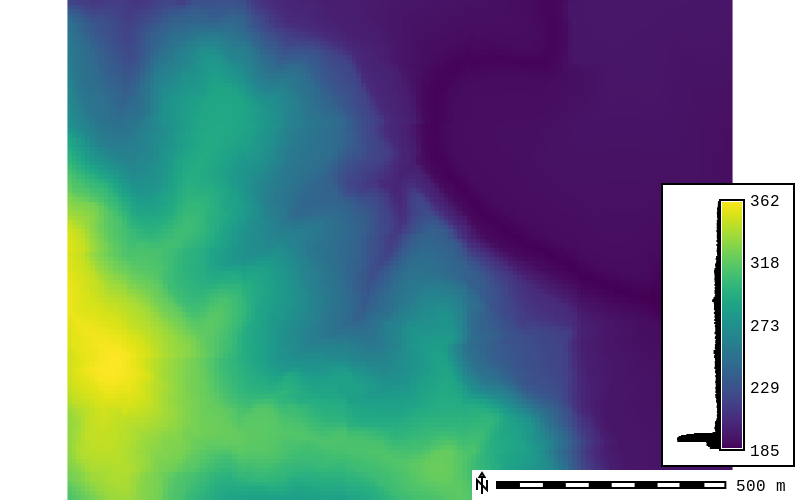

In [23]:
m = gj.Map(use_region=True, height=500, width=800) # Create a map
m.d_rast(map="dem") # Add a raster
m.d_legend(raster="dem", flags="bds", font="Fira Sans:Regular", at="10,60,90,93", fontsize=16) # Add a raster legend
m.d_barscale(at="59,6", fontsize=16, font="Fira Sans:Regular", flags="n") # Add a barscale
m.show()

We can change the color palette of the DEM using the [r.colors](https://grass.osgeo.org/grass-devel/manuals/r.colors.html) command.

In [24]:
gs.run_command("r.colors", map="dem", color="elevation")

Compute some other common DEM derivatives: shaded relief, slope and aspect.

In [25]:
gs.run_command("r.relief", input="dem", output="relief", scale=1, zscale=1)

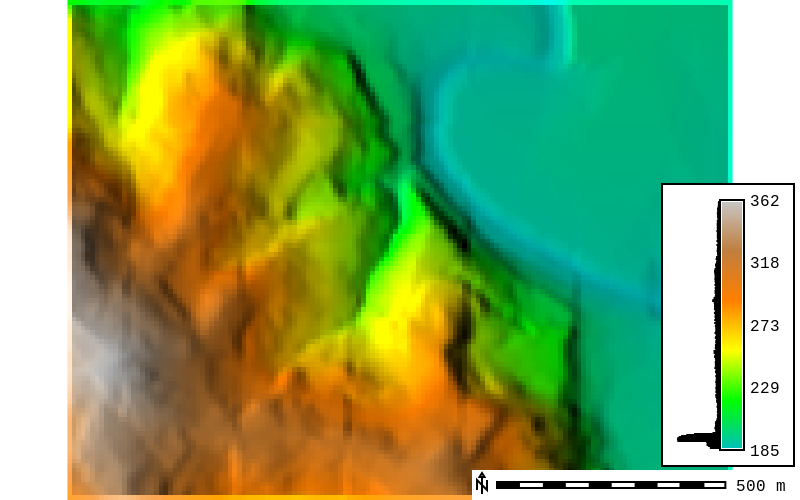

In [27]:
m = gj.Map(use_region=True, height=500, width=800)
m.d_shade(shade="relief", color="dem", brighten=30)
m.d_legend(raster="dem", flags="bds", font="Fira Sans:Regular", at="10,60,90,93", fontsize=16) # Add a raster legend
m.d_barscale(at="59,6", fontsize=16, font="Fira Sans:Regular", flags="n") # Add a barscale
m.show()

**Try it yourself!**

Compute and display the slope and aspect using [`r.slope.aspect`](https://grass.osgeo.org/grass85/manuals/r.slope.aspect.html). Try changing the color map for the slope raster using [`r.colors`](https://grass.osgeo.org/grass85/manuals/r.colors.html). _Bonus Challenge_: Can you add a legend to your visualization with a histogram showing the range of slope values?

<details>
    <summary>👉 <b>click to see hint</b></summary>
  
Looking at the manual for r.slope.aspect, your code should be formatted like:

```python
gs.run_command("r.slope.aspect", elevation=.., slope=.., aspect=..)
```

To get the legend and histogram, look at the flag options in `d.legend`. Remember that `d.legend` can be called by `grass.jupyter.Map()` with `m.d_legend()`. See above for examples.

</details>


<details>
    <summary>👉 <b>click to see solution</b></summary>
    
```python
gs.run_command("r.slope.aspect", elevation="dem", slope="slope", aspect="aspect")

gs.run_command("r.colors", map="slope", color="sepia", flags="e")

m = gj.Map(use_region=True)
m.d_rast(map="slope")
m.d_legend(raster="slope", flags="bds")
m.show()
```

And for aspect:

```python
m = gj.Map(use_region=True)
m.d_rast(map="aspect")
m.d_legend(raster="aspect", flags="bds")
m.show()
```
</details>


Since we're going to interpolate surfaces from points, we'll randomly sample points from the DEM. We could think of these as LiDAR points or ground sampled points.

In [28]:
gs.run_command("r.random", input="dem", vector="elev_points", n=500, flags="sz")

Now, visualize the points.

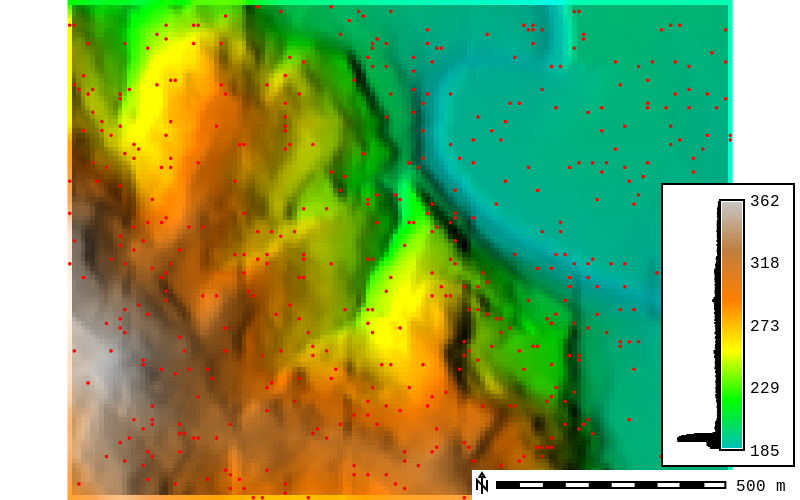

In [35]:
m = gj.Map(use_region=True, height=500, width=800)
m.d_shade(shade="relief", color="dem", brighten=30)
m.d_vect(map="elev_points", color="red", fillcolor="red", icon="basic/point")
m.d_legend(raster="dem", flags="bds", font="Fira Sans:Regular", at="10,60,90,93", fontsize=16)
m.d_barscale(at="59,6", fontsize=16, font="Fira Sans:Regular", flags="n")
m.show()

<a name="R"></a>

---

## Conditional Gaussian Simulations in R

To do our Conditional Gaussian simulations, we'll move to R. We're going to use the `rgrass` library to read and write data to/from GRASS and we'll use `gstat` to do simulate 100 DEMs.

**Install and Import R LIbraries**

First, load the rpy2 extension. rpy2 is an interface to R running embedded in a Python process allowing up to continue operating in our current Python session but cells in R. Fancy! This is only necessary here because we're using R from within our Python process. Check out [here](https://grass-tutorials.osgeo.org//content/tutorials/get_started/fast_track_grass_and_R.html) for an introduction for GRASS in R.

In [36]:
%load_ext rpy2.ipython

Now, we can use the %%R cell magic. When this cell is interpreted, it's contents will be sent to R. We could also use line magic now with %R which would only send the line to R.

In [37]:
%%R
system("apt-get install r-cran-sf r-cran-rgrass r-cran-gstat r-cran-terra r-cran-devtools r-cran-irkernel")

Load other libraries.

In [38]:
%%R
library(sf)
library(gstat)
library(terra)
library(rgrass)

Linking to GEOS 3.12.1, GDAL 3.4.3, PROJ 8.2.1; sf_use_s2() is TRUE
Linked against: 3.12.1-CAPI-1.18.1 compiled against: 3.10.2-CAPI-1.16.0
It is probably a good idea to reinstall sf (and maybe lwgeom too)
terra 1.8.54
Compiled with:3.10.2-CAPI-1.16.0
 Running with:3.12.1-CAPI-1.18.1

You should reinstall package 'terra'

GRASS GIS interface loaded with GRASS version: GRASS 8.4.1 (2025)
and location: geomorphometry_workshop


**Create Empirical (sample) Variogram**

Use readVECT from rgrass to turn the random elevation points into a [SpatVector](https://rdrr.io/cran/terra/man/SpatVector-class.html), the terra vector class.

In [39]:
%%R
elev_points <- rgrass::read_VECT("elev_points")

         options (parameter 'lco') to export in 3D rather than 2D
         (default).
Exporting 500 features...
   5%  11%  17%  23%  29%  35%  41%  47%  53%  59%  65%  71%  77%  83%  89%  95% 100%
v.out.ogr complete. 500 features (Point type) written to <elev_points>
(GPKG format).


In addition: Warning messages:
1: In execGRASS("v.out.ogr", flags = flags, input = vname, type = type,  :
  The command:
v.out.ogr --overwrite input=elev_points type=point layer=1 output=/tmp/RtmpbRxGEi/file7ec534b790a.gpkg output_layer=elev_points format=GPKG
produced at least one warning during execution:
         options (parameter 'lco') to export in 3D rather than 2D
         (default).
Exporting 500 features...
   5%  11%  17%  23%  29%  35%  41%  47%  53%  59%  65%  71%  77%  83%  89%  95% 100%
v.out.ogr complete. 500 features (Point type) written to <elev_points>
(GPKG format).
2: [vect] Z coordinates ignored 


In [42]:
%%R
head(elev_points)

  cat    value
1   1 215.6513
2   2 199.8491
3   3 206.7190
4   4 198.2128
5   5 195.1920
6   6 195.1651


Compute the cutoff and width of the empirical variogram by using the maximum distance between two points.

In [41]:
%%R

coords <- terra::geom(elev_points)[, c("x", "y")]
dists <- as.matrix(dist(coords))
max_dist <- max(dists)


# By default, gstat uses a cutoff of "the length of the diagonal of the box spanning the data is divided by three."
# Try increasing this to 0.6 or 0.7:
cutoff <- 0.5 * max_dist #<--Modify this coefficient

width <- cutoff / 20
print(paste("Using cutoff:", cutoff, "and width:", width))

[1] "Using cutoff: 861.423240921674 and width: 43.0711620460837"


With the width and cutoff, we can computate the variogram. First, convert to random sample points to an `sf` dataframe since that is the input format for `gstat`.

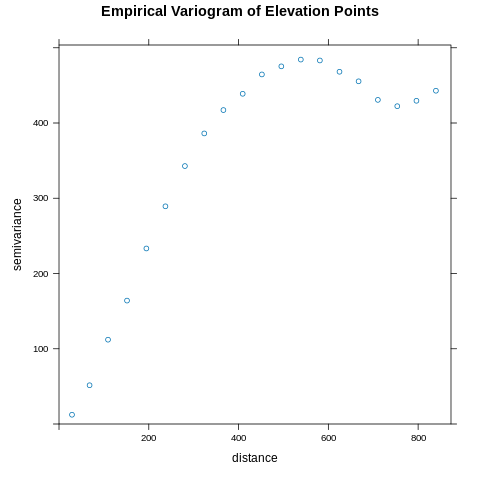

In [44]:
%%R
elev_df <- terra::as.data.frame(elev_points, geom = "XY")
g <- gstat::gstat(formula = value ~ x + y, locations = ~x + y, data = elev_df)
vg <- gstat::variogram(g, cutoff=cutoff, width=width)


plot(vg, main = "Empirical Variogram of Elevation Points")

Now, we're going to fit a Matern Covariance function to the empirical variogram. First, we'll fit Kappa using `cgSim` library that Dr. Corey White has been working on. We pass the empirical variogram as the input.

In [52]:
%%R
#' @title Optimize kappa for a Matérn variogram
#' @description Uses WLS to fit variograms for different kappa and finds the best one.
#' @param vg A gstat variogram object (from gstat::variogram)
#' @param kappa_range Numeric vector of length 2, bounds for optimization (e.g., c(0.1, 5))
#' @return A list with best fitted model and selected kappa
#' @importFrom gstat vgm fit.variogram
#' @export
optimize_kappa <- function(vg, kappa_range = c(0.1, 5)) {
    f <- function(x) {
        tryCatch(
            {
                vfit <- gstat::fit.variogram(vg, model = gstat::vgm(model = "Mat", nugget = NA, kappa = x))
                attr(vfit, "SSErr")
            },
            error = function(e) Inf
        )
    }
    result <- optimize(f, kappa_range)
    best_kappa <- result$minimum
    vfit_best <- gstat::fit.variogram(vg, model = gstat::vgm(model = "Mat", nugget = NA, kappa = best_kappa))
    list(model = vfit_best, kappa = best_kappa, SSErr = result$objective)
}
# Fit kappa
fit_kappa <- optimize_kappa(vg)

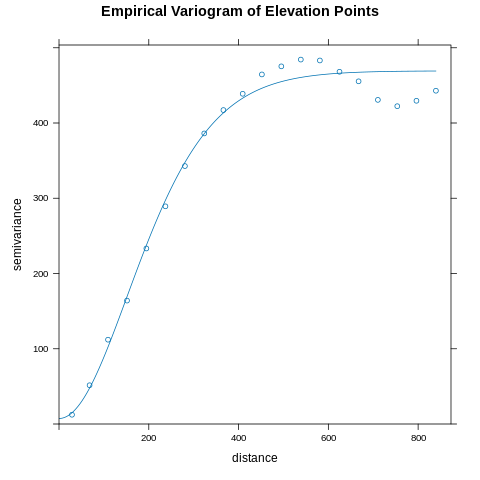

In [50]:
%%R
plot(vg, model = fit_kappa$model, main = "Empirical Variogram of Elevation Points")

Let's see some information about our fitted variogram:

In [51]:
%%R
head(fit_kappa)

$model
  model     psill    range   kappa
1   Nug   7.28246  0.00000 0.00000
2   Mat 462.01380 55.84951 4.99992

$kappa
[1] 4.99992

$SSErr
[1] 129.3551



Time to interpolate our DEMs using the fitted variogram. We will only do 10 simulations since the process is computationally intensive but in the GitHub repo, we've included a set of 90 pre-computed simulations that we'll import after this for computed extracted stream uncertainty.

Create a 10m resolution grid for prediction:

TODO: Can it be less than 10m so that it runs faster? What about 30m?

In [53]:
%%R
dem_rast= rgrass::read_RAST("dem")
grid_ext <- terra::ext(dem_rast)
grid_res <- 10

xy <- expand.grid(
  x = seq(grid_ext[1], grid_ext[2], by = grid_res),
  y = seq(grid_ext[3], grid_ext[4], by = grid_res)
)

Checking GDAL data type and nodata value...
   2%   5%   8%  11%  14%  17%  20%  23%  26%  29%  32%  35%  38%  41%  44%  47%  50%  53%  56%  59%  62%  65%  68%  71%  74%  77%  80%  83%  86%  89%  92%  95%  98% 100%
Using GDAL data type <Float32>
Exporting raster data to RRASTER format...
   2%   5%   8%  11%  14%  17%  20%  23%  26%  29%  32%  35%  38%  41%  44%  47%  50%  53%  56%  59%  62%  65%  68%  71%  74%  77%  80%  83%  86%  89%  92%  95%  98% 100%
r.out.gdal complete. File </tmp/RtmpbRxGEi/file7ec122e1ca4.grd> created.


Run 2 stochastic conditional gaussian simulations, creating 10 DEMs using `gstat::krige`.

In [56]:
%%R
N.sim <- 12

In [57]:
%%R
sims <- gstat::krige(
  formula = value ~ x + y,
  locations = ~ x + y,
  data = elev_df,
  newdata = xy,
  model = fit_kappa$model,
  nsim = N.sim,
  nmax = 40,
  maxdist = 500,
  debug.level = -1
)

drawing 12 GLS realisations of beta...
[using conditional Gaussian simulation]
100% done


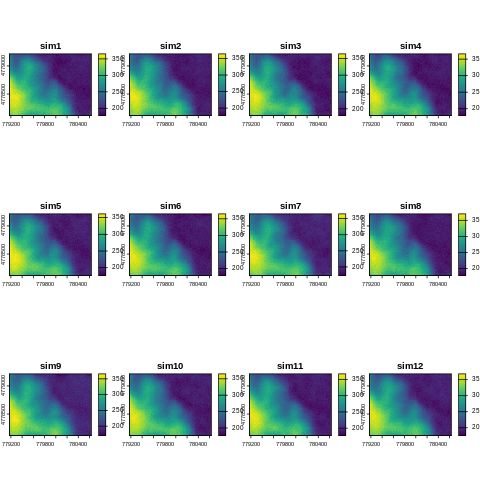

In [58]:
%%R
sim_rast <- terra::rast(sims, crs = terra::crs(dem_rast))
terra::plot(sim_rast)

In [59]:
%%R
for (i in 1:N.sim) {
    rgrass::write_RAST(sim_rast[[i]], paste0("sim_", i))
}

Importing raster map <sim_1>...
   0%   3%   6%   9%  12%  15%  18%  21%  24%  27%  30%  33%  36%  39%  42%  45%  48%  51%  54%  57%  60%  63%  66%  69%  72%  75%  78%  81%  84%  87%  90%  93%  96%  99% 100%
Importing raster map <sim_2>...
   0%   3%   6%   9%  12%  15%  18%  21%  24%  27%  30%  33%  36%  39%  42%  45%  48%  51%  54%  57%  60%  63%  66%  69%  72%  75%  78%  81%  84%  87%  90%  93%  96%  99% 100%
Importing raster map <sim_3>...
   0%   3%   6%   9%  12%  15%  18%  21%  24%  27%  30%  33%  36%  39%  42%  45%  48%  51%  54%  57%  

SpatRaster read into GRASS using r.in.gdal from memory
SpatRaster read into GRASS using r.in.gdal from memory
SpatRaster read into GRASS using r.in.gdal from memory
SpatRaster read into GRASS using r.in.gdal from memory
SpatRaster read into GRASS using r.in.gdal from memory
SpatRaster read into GRASS using r.in.gdal from memory
SpatRaster read into GRASS using r.in.gdal from memory
SpatRaster read into GRASS using r.in.gdal from memory
SpatRaster read into GRASS using r.in.gdal from memory
SpatRaster read into GRASS using r.in.gdal from memory
SpatRaster read into GRASS using r.in.gdal from memory
SpatRaster read into GRASS using r.in.gdal from memory


The `run_sim` function writes these rasters into GRASS. Use the GRASS R API to list the simulated rasters:

In [60]:
%%R
execGRASS("g.list", type="raster", pattern="sim_*")

sim_1
sim_10
sim_11
sim_12
sim_2
sim_3
sim_4
sim_5
sim_6
sim_7
sim_8
sim_9


Calculate the mean and standard deviation of the simulatate surfaces

In [61]:
%%R
execGRASS("g.list", type="raster", pattern="sim_*", output="tmp_list_simulated.txt")
execGRASS("r.series", file="tmp_list_simulated.txt", output="simulated_mean", method="average")
execGRASS("r.series", file="tmp_list_simulated.txt", output="simulated_std", method="stddev")

   0%   3%   6%   9%  12%  15%  18%  21%  24%  27%  30%  33%  36%  39%  42%  45%  48%  51%  54%  57%  60%  63%  66%  69%  72%  75%  78%  81%  84%  87%  90%  93%  96%  99% 100%
   0%   3%   6%   9%  12%  15%  18%  21%  24%  27%  30%  33%  36%  39%  42%  45%  48%  51%  54%  57%  60%  63%  66%  69%  72%  75%  78%  81%  84%  87%  90%  93%  96%  99% 100%


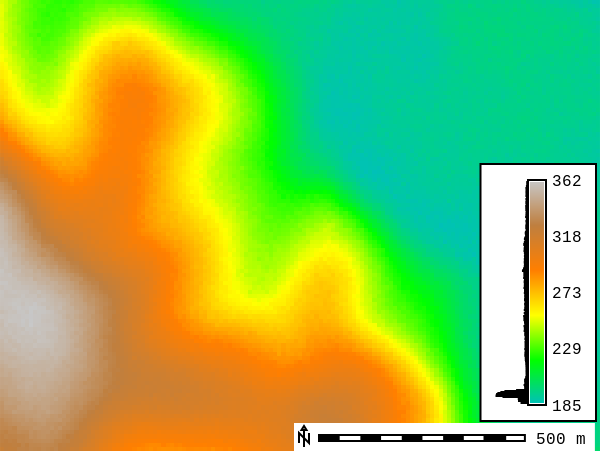

In [70]:
m = gj.Map(use_region=True)
gs.run_command("r.colors", map="simulated_mean", color="elevation")
m.d_rast(map="simulated_mean")
m.d_legend(raster="dem", flags="bds", font="Fira Sans:Regular", at="10,60,88,91", fontsize=16)
m.d_barscale(at="49,6", fontsize=16, font="Fira Sans:Regular", flags="n")
m.show()

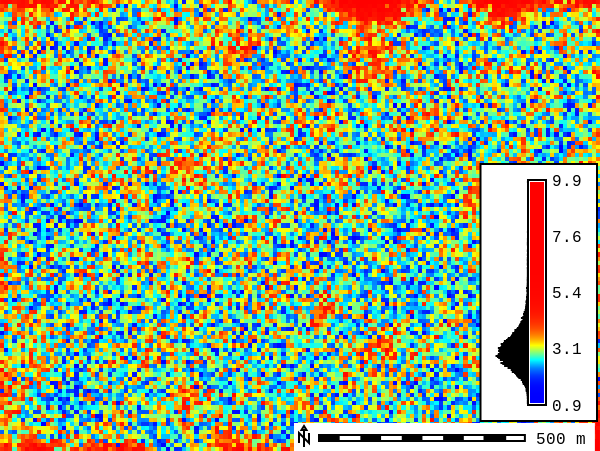

In [76]:
m = gj.Map(use_region=True)
gs.run_command("r.colors", map="simulated_std", color="bcyr", flags="e")
m.d_rast(map="simulated_std")
m.d_legend(raster="simulated_std", flags="bds", font="Fira Sans:Regular", at="10,60,88,91", fontsize=16)
m.d_barscale(at="49,6", fontsize=16, font="Fira Sans:Regular", flags="n")
m.show()

<a name="uncert"></a>

---

## Extract Streams and Compute Uncertainty

**Generate streams for each DEM**

For this, we will use the [`r.watershed`](https://grass.osgeo.org/grass-devel/manuals/r.watershed.html) tool with a threshold of 10,000 (i.e. a cells with a flow accumulation above 10,000 will be classified as a stream).

In [77]:
%%R
N.sim <- 10
for(i in 1:N.sim) {execGRASS("r.watershed", elevation=paste("sim_", i, sep=""),
 threshold=1000, stream=paste("stream_", i, sep=""), flags=c("quiet"))}

**Calculate the probablity and error**


First, count the number of times a cell was predicted to be a stream:

In [78]:
%%R
execGRASS("g.list", type="raster", pattern="stream*", output="tmp_list_stream.txt")
execGRASS("r.series", file="tmp_list_stream.txt", output="count", method="count")

   0%   3%   6%   9%  12%  15%  18%  21%  24%  27%  30%  33%  36%  39%  42%  45%  48%  51%  54%  57%  60%  63%  66%  69%  72%  75%  78%  81%  84%  87%  90%  93%  96%  99% 100%


Then, convert to probability by dividing the number of simulations:

In [79]:
%%R
execGRASS("r.mapcalc", expression=paste("prob = float(count)/", N.sim))

Following Hengl et al. [(2010)](https://hess.copernicus.org/articles/14/1153/2010/), we use measure the error ($H(s)$) using the Shannon Entropy [(Shannon, 1949)](https://ieeexplore.ieee.org/abstract/document/6773024):

$$
H(s) = −p(s) * log(p(s)) -[1 − p(s)] * log(1 - p(s))
$$

where $p$ is the probability a given cell, $s$, is a stream.

In [80]:
%%R
execGRASS("r.mapcalc", expression="error = -prob * log(prob) - (1-prob)* log(1-prob)")

Now, visulalize the results. First, the probability that a cell contains a stream:

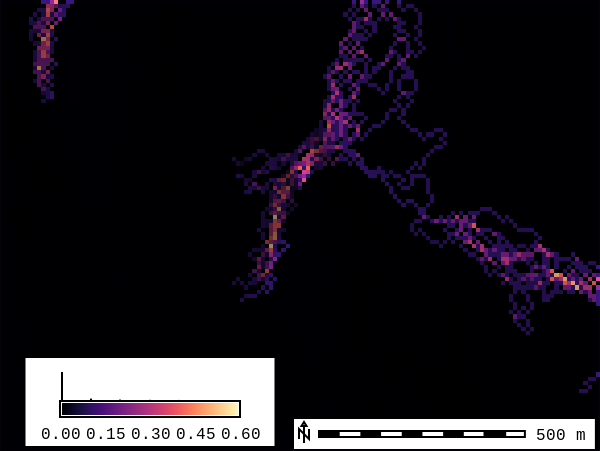

In [93]:
m = gj.Map()
gs.run_command("r.colors", map="prob", color="magma", flags="")
m.d_shade(shade="relief", color="prob", brighten=30)
m.d_legend(raster="prob", flags="bds", font="Fira Sans:Regular", at="7.5,11,10,40", fontsize=16)
m.d_barscale(at="49,7", fontsize=16, font="Fira Sans:Regular", flags="n")
m.show()

And next, the uncertainty:

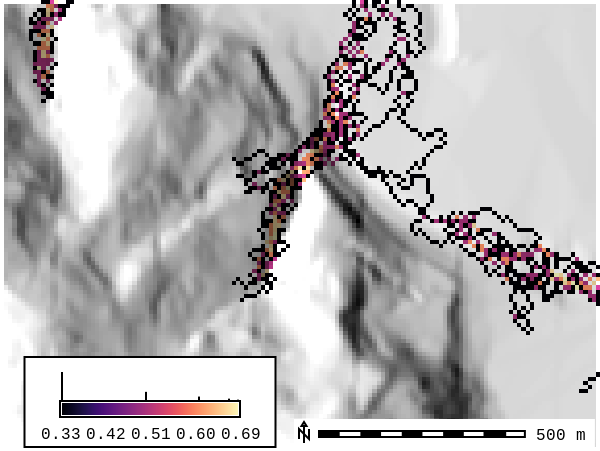

In [95]:
m =gj.Map()
gs.run_command("r.colors", map="error", color="magma", flags="")
m.d_shade(shade="relief", color="error", brighten=30)
m.d_legend(raster="error", flags="bds", font="Fira Sans:Regular", at="7.5,11,10,40", fontsize=16)
m.d_barscale(at="49,7", fontsize=16, font="Fira Sans:Regular", flags="n")
m.show()

---

### Exercise

Compare the output with a surface computed with a regularized spline with tension [`v.surf.rst`](https://grass.osgeo.org/grass-devel/manuals/v.surf.rst.html). Experiment with changing the tension and smoothing parameters.

---

### Publication Quality Figures with grass.jupyter

In this section, we show some of the features of grass.jupyter.Map() and some tricks for making nice, publication quality figures.

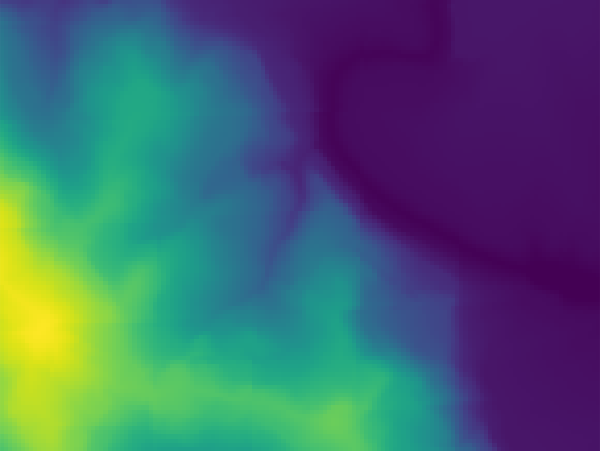

In [48]:
m =gj.Map()
m.d_rast(map="dem")
m.show()

Any tool from the [display family](https://grass.osgeo.org/grass-devel/manuals/display.html) can be used with Map objects by calling the tool as a method and replacing "." with "_". For example, the following code calls [`d.shade`](https://grass.osgeo.org/grass-devel/manuals/d.shade.html) and [`d.barscale`](https://grass.osgeo.org/grass-devel/manuals/d.barscale.html).

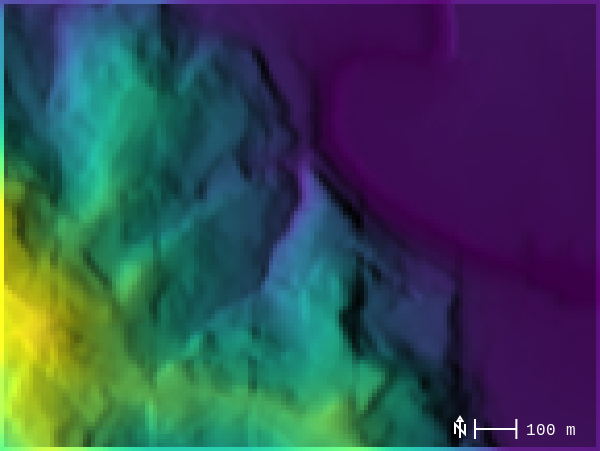

In [49]:
m = gj.Map(use_region=True)
m.d_shade(shade="relief", color="dem", brighten=30)
m.d_barscale(at="75,8", length=100, fontsize=16, style="line", flags="n", color="white", bgcolor="none")
m.show()

**Raster Colors**

Raster colortables are handled by the [`r.colors`](https://grass.osgeo.org/grass-devel/manuals/r.colors.html) tool. There are many pre-determined colortables and you can also define your own with rules.

In [50]:
gs.run_command("r.colors", map="dem", color="elevation")

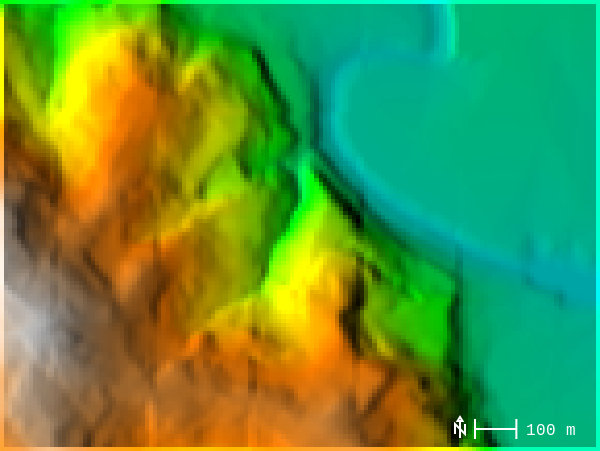

In [51]:
m = gj.Map(use_region=True)
m.d_shade(shade="relief", color="dem", brighten=30)
m.d_barscale(at="75,8", length=100, fontsize=16, style="line", flags="n", color="white", bgcolor="none")
m.show()

We can also use the [`r.colors.matplotlib`](https://grass.osgeo.org/grass-devel/manuals/addons/r.colors.matplotlib.html) to use colors from the matplotlib colormap [library](https://matplotlib.org/stable/users/explain/colors/colormaps.html)

In [52]:
gs.run_command("g.extension", extension="r.colors.matplotlib")

In [53]:
gs.run_command("r.colors.matplotlib", color="terrain", map="dem")

**Vector Styling**

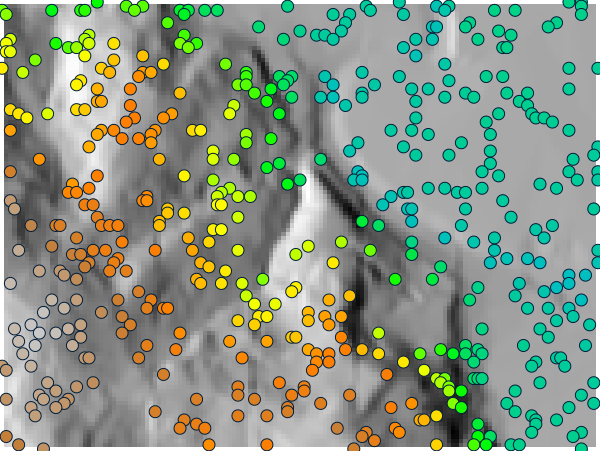

In [54]:
vmap = gj.Map(use_region=True)
vmap.d_rast(map="relief")
vmap.d_vect(map="elev_points", zcolor="elevation", icon="basic/circle", size=12)
vmap.show()

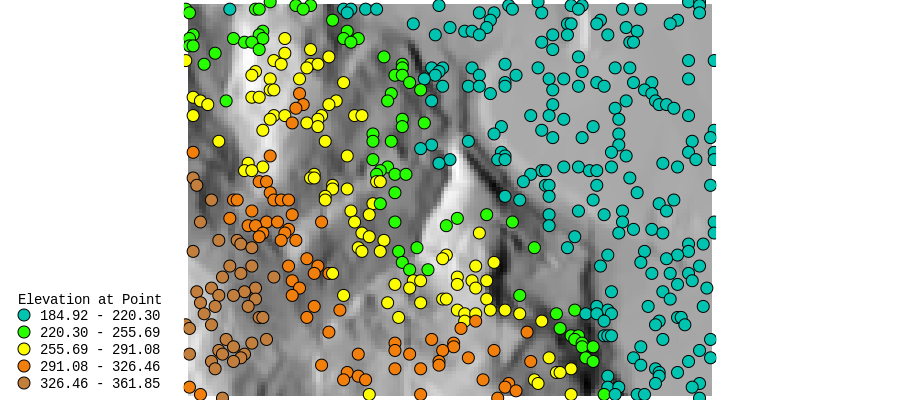

In [56]:
vmap = gj.Map(use_region=True, width=900, height=400)
vmap.d_rast(map="relief")
vmap.d_vect_thematic(
    map="elev_points",
    column="value",
    algorithm="int",
    nclasses=5,
    color="0:195:176,39:255:0,251:253:0,242:127:11,193:126:60",
    icon="basic/circle",
    size=12,
    legend_title="Elevation at Point")
vmap.d_legend_vect(flags="b", at="2,28", symbol_size=12, border_color="none")
vmap.show()

**Creating Multipane Figures**

All grass.jupyter visualization classes have a `save()` method.

In [61]:
m.save("dem.png")


Behind the scenes, grass.jupyter.Map() is creating a temporary png image which can also be directly accessed with:

In [62]:
m.filename

'/tmp/tmpbqdgj7sd/map.png'

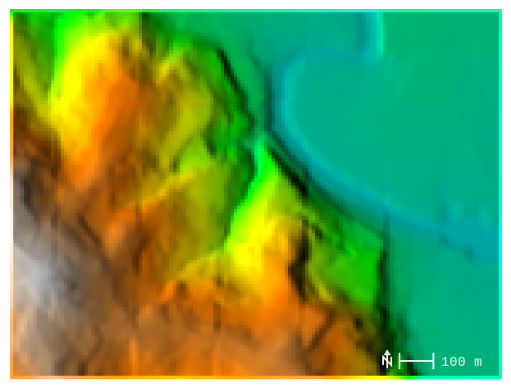

In [63]:
from PIL import Image
import matplotlib.pyplot as plt

plt.imshow(Image.open(m.filename))
plt.axis('off')
plt.show()

This makes it easy to combine maps created with grass.jupyter.Map() with other elements to create multipane figures. For example, here, we show a two-pane figure with `m` and a seaborn histogram of elevation values. This example also shows how GRASS rasters can be converted to numpy arrays.

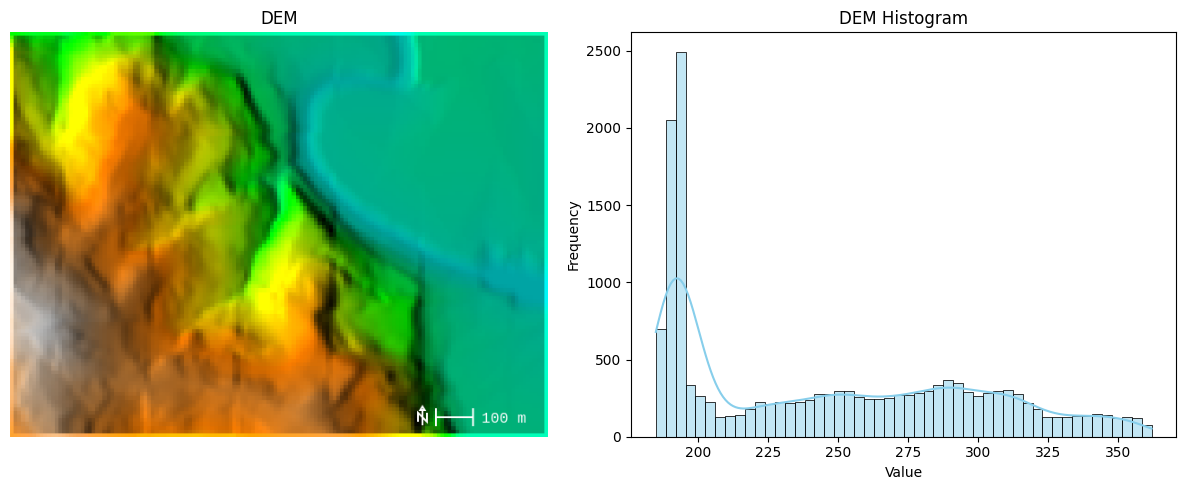

In [60]:
import seaborn as sns
import grass.script.array as garray

# Get GRASS Elevation Raster as np array
elev = garray.array("dem").flatten()

# Create the multipane figure
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Panel 1: Image
axes[0].imshow(Image.open(m.filename))
axes[0].axis('off')
axes[0].set_title('DEM')

# Panel 2: Histogram
sns.histplot(elev, bins=50, kde=True, ax=axes[1], color='skyblue')
axes[1].set_title('DEM Histogram')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Frequency')

# Adjust layout and display
plt.tight_layout()
plt.show()